In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras import layers

**Load data**

In [2]:
df = pd.read_csv('GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-01,778.549988,778.599976,753.359985,764.330017,764.330017,2867100
1,2016-12-02,761.900024,770.500000,759.000000,764.460022,764.460022,1718800
2,2016-12-05,770.000000,780.000000,766.969971,778.219971,778.219971,1688500
3,2016-12-06,780.190002,785.280029,773.320007,776.179993,776.179993,1734100
4,2016-12-07,779.950012,792.000000,773.530029,791.469971,791.469971,2029400


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1252,2021-11-22,2986.649902,2996.590088,2922.949951,2926.040039,2926.040039,1529700
1253,2021-11-23,2923.060059,2933.199951,2882.300049,2915.639893,2915.639893,1360900
1254,2021-11-24,2909.469971,2924.989990,2887.459961,2922.399902,2922.399902,902000
1255,2021-11-26,2886.969971,2891.149902,2836.850098,2843.659912,2843.659912,1523500
1256,2021-11-29,2880.000000,2925.949951,2877.870117,2910.610107,2910.610107,1629800


In [4]:
df.shape

(1257, 7)

In [5]:
close_df = df['Close'] # this is our dependent variable for our stock price 
close_df.shape

(1257,)

In [6]:
close_df.describe()

count    1257.000000
mean     1406.595044
std       552.130782
min       764.330017
25%      1054.140015
50%      1192.530029
75%      1518.660034
max      2996.770020
Name: Close, dtype: float64

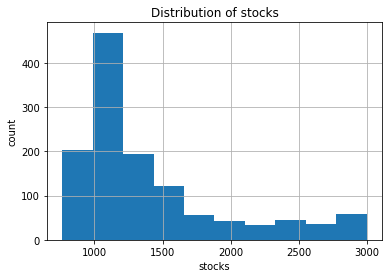

In [7]:
close_df.hist()
plt.xlabel('stocks')
plt.ylabel('count')
plt.title('Distribution of stocks')
plt.show()

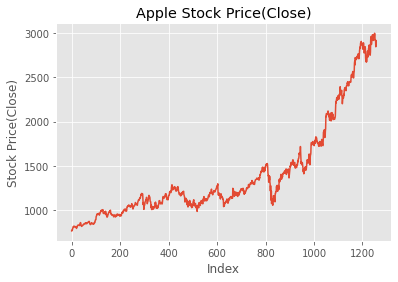

In [8]:
# graph visualisation of stock data
plt.style.use('ggplot')
plt.plot(close_df)
plt.xlabel('Index')
plt.ylabel('Stock Price(Close)')
plt.title('Apple Stock Price(Close)')
plt.show()

**Train test split**

In [9]:
# splitting dataset into trian and test
training_size = int(len(close_df) * 0.65) # 65% train size
test_size = len(close_df) - training_size # 35% test size
train_data, test_data = close_df[0:training_size], close_df[training_size:] 
test_data.shape
train_data.shape

(817,)

**Data sequencing**

In [10]:
#converting an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset.iloc[i:(i+time_step)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step])
    return np.array(dataX), np.array(dataY)

In [11]:
# splitting dataset into trian and test
time_step = 100
x_train ,y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

**MinMax scaling**

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler(feature_range= (0,1)) 
scaler_y = MinMaxScaler(feature_range= (0,1)) 

scaled_x_train = scaler_x.fit_transform(x_train)
scaled_y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
# transformt the test data

scaled_x_test = scaler_x.transform(x_test)
scaled_y_test = scaler_y.transform(y_test.reshape(-1, 1))

**Reshape data**

In [13]:
# reshape input into 3D in order to fit into LSTM
scaled_x_train = scaled_x_train.reshape(scaled_x_train.shape + (1,))
scaled_x_test = scaled_x_test.reshape(scaled_x_test.shape + (1,))
print(scaled_x_train.shape, scaled_x_test.shape)

(717, 100, 1) (340, 100, 1)


**Creating Model**

In [14]:
model = Sequential()
model.add(layers.LSTM(units=100, return_sequences=True, input_shape=(100,1), dropout=0.2))
model.add(layers.LSTM(units=10, return_sequences=True, dropout=0.2))
model.add(layers.LSTM(units=10, return_sequences=True, dropout=0.2))
model.add(layers.LSTM(units=10, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 lstm_1 (LSTM)               (None, 100, 10)           4440      
                                                                 
 lstm_2 (LSTM)               (None, 100, 10)           840       
                                                                 
 lstm_3 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 46,931
Trainable params: 46,931
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
# implementing early stopping and model check point 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# stop training process if the val_loss of the train data is not decreased after 5 epochs
es = EarlyStopping(monitor= "val_loss" , min_delta= 0, patience= 5, verbose=1)

# do not save the weights until and unless the validation loss is not decreased.
mc = ModelCheckpoint(filepath= "saved models/Stacked LSTM for apple Stocks.h5",
                     monitor="val_loss", verbose=1, save_best_only= True)

In [17]:
hist = model.fit(scaled_x_train, scaled_y_train, validation_data=(scaled_x_test, scaled_y_test), 
epochs=100, batch_size=3, verbose=1, callbacks=[es,mc])

Epoch 1/100
239/239 [==============================] - ETA: 0s - loss: 0.0145
Epoch 00001: val_loss improved from inf to 1.29964, saving model to saved models/Stacked LSTM for apple Stocks.h5
239/239 [==============================] - 33s 115ms/step - loss: 0.0145 - val_loss: 1.2996
Epoch 2/100
239/239 [==============================] - ETA: 0s - loss: 0.0095
Epoch 00002: val_loss did not improve from 1.29964
239/239 [==============================] - 26s 109ms/step - loss: 0.0095 - val_loss: 1.4062
Epoch 3/100
239/239 [==============================] - ETA: 0s - loss: 0.0095
Epoch 00003: val_loss did not improve from 1.29964
239/239 [==============================] - 26s 111ms/step - loss: 0.0095 - val_loss: 1.5062
Epoch 4/100
239/239 [==============================] - ETA: 0s - loss: 0.0079
Epoch 00004: val_loss did not improve from 1.29964
239/239 [==============================] - 26s 109ms/step - loss: 0.0079 - val_loss: 1.4328
Epoch 5/100
239/239 [==============================] 

In [18]:
# list all data in history
print(hist.history.keys())  #loss and accuracy belongs to input

dict_keys(['loss', 'val_loss'])


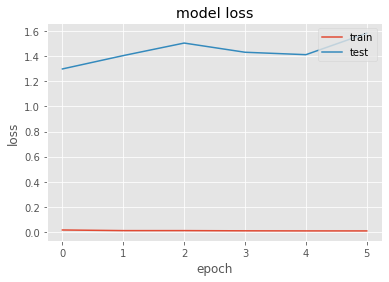

In [19]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Load model**

In [20]:
from tensorflow.keras.models import load_model
Model = load_model('saved models/Stacked LSTM for apple Stocks.h5')

In [21]:
## evaluation on train data
Model.evaluate(scaled_x_train, scaled_y_train, batch_size=1)

717/717 [==============================] - 16s 20ms/step - loss: 0.0063


0.006314385216683149

In [22]:
## evaluation on test data
Model.evaluate(scaled_x_test, scaled_y_test, batch_size=1)

340/340 [==============================] - 7s 21ms/step - loss: 1.2996


1.2996439933776855

**Analyze RMSE**

In [23]:
train_pred = Model.predict(scaled_x_train)
test_pred = Model.predict(scaled_x_test)

In [24]:
import math
from sklearn.metrics import mean_squared_error
## rmse on test data
math.sqrt(mean_squared_error(scaled_y_test, test_pred))

1.1400191622308524

In [25]:
## rmse on train data
math.sqrt(mean_squared_error(scaled_y_train, train_pred))

0.07946308617764848

In [26]:
# Transform Prediction data back into original form
inv_train_pred = scaler_y.inverse_transform(train_pred)
inv_test_pred = scaler_y.inverse_transform(test_pred)

In [27]:
# calculate RMSE Performance metrics(Root Mean squared Error) for Train data
math.sqrt(mean_squared_error(y_train, inv_train_pred))

50.33430457254528

In [28]:
# RMSE for test data
math.sqrt(mean_squared_error(y_test, inv_test_pred))

722.1223041756128

**Results**

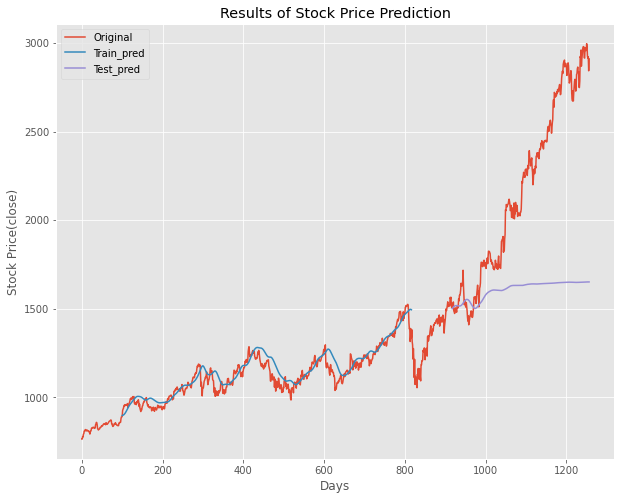

In [29]:
### Plotting 
plt.figure(figsize=(10, 8))

# shift train predictions for plotting(orange)
look_back=100
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(inv_train_pred)+look_back] = inv_train_pred.reshape(inv_train_pred.shape[0])

# shift test predictions for plotting(green)
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:] = np.nan
testPredictPlot[len(inv_train_pred)+(look_back*2):len(close_df)] = inv_test_pred.reshape(inv_test_pred.shape[0])

# plot baseline and predictions (blue)
plt.plot(close_df, label='Original')
plt.plot(trainPredictPlot, label='Train_pred')
plt.plot(testPredictPlot, label='Test_pred')

plt.title('Results of Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price(close)')
plt.legend(loc='best')
plt.show()

**Forecasting**

In [30]:
x_input = y_test[240:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
# scale the input data
sc_x_input = scaler_x.transform(x_input)

In [32]:
temp_input = sc_x_input[0].tolist()

**1-month prediction**

In [33]:
n_steps = len(temp_input)
for i in range(30):
    input_ = temp_input[i:]
    input_ = np.array(input_).reshape(1, n_steps, 1)
    output = Model.predict(input_)[0][0]
    temp_input.append(output) 

In [34]:
len(temp_input)

130

In [35]:
# collect numbers for 100 and 30 days
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

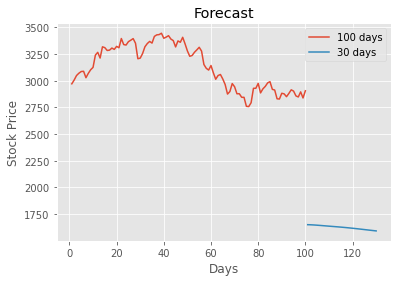

In [36]:
# Partial Plot in which Blue plot is forecast on 30 days
plt.plot(day_new, scaler_y.inverse_transform(np.array(temp_input[:100]).reshape(-1,1)), label='100 days')
plt.plot(day_pred, scaler_y.inverse_transform(np.array(temp_input[100:]).reshape(-1,1)), label='30 days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Forecast')
plt.legend(loc='best')
plt.show()

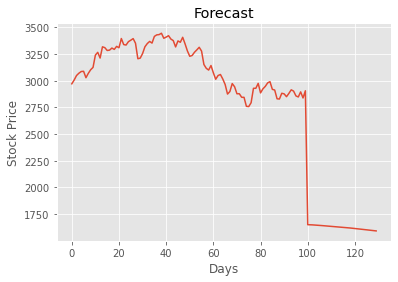

In [37]:
# Plotting the partial Forecast
plt.plot(scaler_y.inverse_transform(np.array(temp_input).reshape(-1,1)))
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Forecast')
plt.show()

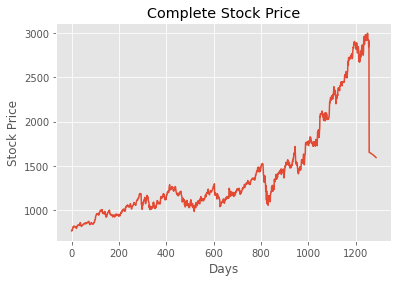

In [38]:
# plotting the complete Graph along with 30 days Forecast
stock_previous = close_df.to_numpy()
stock_30 = scaler_y.inverse_transform(np.array(temp_input[100:]).reshape(1, -1))[0]
Total_stock = np.concatenate([stock_previous, stock_30])
plt.plot(Total_stock)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Complete Stock Price')
plt.show()